In [1]:
#files failed processing: 300to470

import awkward as ak
import numpy as np
import time
import coffea

print(coffea.__version__)
from coffea import util
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
files = [
    "root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL17NanoAODv9/QCD_Pt_170to300_TuneCP5_13TeV_pythia8/NANOAODSIM/106X_mc2017_realistic_v9-v1/120000/0CDD30E0-B953-E54B-BB7A-BFB45BE6EC93.root",
  "root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL17NanoAODv9/QCD_Pt_300to470_TuneCP5_13TeV_pythia8/NANOAODSIM/106X_mc2017_realistic_v9-v1/120000/3788BBD3-3B70-BE48-B01A-4FA395E1E0B6.root",
  "root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL17NanoAODv9/QCD_Pt_470to600_TuneCP5_13TeV_pythia8/NANOAODSIM/106X_mc2017_realistic_v9-v1/70000/F6B6A983-3E2B-7B4D-A2CE-E03AB6E32387.root",
  "root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL17NanoAODv9/QCD_Pt_600to800_TuneCP5_13TeV_pythia8/NANOAODSIM/106X_mc2017_realistic_v9-v1/70000/FDF7FBE4-9226-994A-BD45-29995A3CD62F.root",
  "root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL17NanoAODv9/QCD_Pt_800to1000_TuneCP5_13TeV_pythia8/NANOAODSIM/106X_mc2017_realistic_v9-v1/70000/2CEB03D7-5B1A-EE46-9C21-13ED3E349AF4.root",
  "root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL17NanoAODv9/QCD_Pt_1000to1400_TuneCP5_13TeV_pythia8/NANOAODSIM/106X_mc2017_realistic_v9-v1/70000/DB87A517-0584-1A41-BB18-AAE7C9AAE5B8.root",
  "root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL17NanoAODv9/QCD_Pt_1400to1800_TuneCP5_13TeV_pythia8/NANOAODSIM/106X_mc2017_realistic_v9-v1/280000/BFE2E7E9-82CB-FE47-9B43-EBA5C373AF60.root",
  "root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL17NanoAODv9/QCD_Pt_1800to2400_TuneCP5_13TeV_pythia8/NANOAODSIM/106X_mc2017_realistic_v9-v1/70000/5213B536-BAA1-CC43-A58A-B1E41E2680F5.root",
  "root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL17NanoAODv9/QCD_Pt_2400to3200_TuneCP5_13TeV_pythia8/NANOAODSIM/106X_mc2017_realistic_v9-v1/280000/E8400F91-3216-EA46-A9F1-8CC7EF5261B0.root",
  "root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL17NanoAODv9/QCD_Pt_3200toInf_TuneCP5_13TeV_pythia8/NANOAODSIM/106X_mc2017_realistic_v9-v1/280000/B21BFDD8-B878-784C-AFB6-5CDE131F5C39.root"
]
#/store/mc/RunIISummer20UL17NanoAODv9/QCD_Pt_3200toInf_TuneCP5_13TeV_pythia8/NANOAODSIM/106X_mc2017_realistic_v9-v1/70000/7CB92FEA-6DFF-7647-9D7A-094D1F84245B.root has timeout error
events = NanoEventsFactory.from_root(files[0], schemaclass=NanoAODSchema).events()

0.7.15


In [2]:
from coffea import processor, hist

##### TO DO #####
#make mass vs pt and response matrix (pt_gen, mass_gen, pt_reco, mass_reco)
# Add eta/phi/delta_r/pt cuts fully
# Make 2 eta collections --> high eta (>1.7) and central (<1.7)
# add same cuts on GenJetAK8
# find misses --> need to do deltaR matching by hand --> if no reco miss
# do Rivet routine
# make central (eta < 1.7) and high eta bins (1.7 < eta < 2.5)
# try AK4 jets to give low pT ??
# remove phi cuts --  why past me why?? do you mean try with and without phi cuts?

#bcut options: b_loose (apply loose bTag threshold to only hardest jet), bb_loose (apply loose bTag to leading two jets),
#              b_med(apply medium bTag to only the hardest jet), bb_med (apply medium bTag to leading two jets)

bTag_options = ['bbloose', 'bloose', 'bbmed', 'bmed']
def applyBTag(events, btag):
    print('btag input: ', btag, '\n')
    if (btag == 'bbloose'):
        events = events[(events.FatJet[:,0].btagCSVV2 >= 0.460) & (events.FatJet[:,1].btagCSVV2 >= 0.460)]
        print('Loose WP CSV V2 B tag applied to leading two jets')
    elif (btag == 'bloose'):
        events = events[(events.FatJet[:,0].btagCSVV2 >= 0.460)]
        print('Loose WP CSV V2 B tag applied to leading jet only')
    elif (btag == 'bbmed'):
        events = events[(events.FatJet[:,0].btagCSVV2 >= 0.80) & (events.FatJet[:,1].btagCSVV2 >= 0.80)]
        print('Medium WP CSV V2 B tag applied to first two jets')
    elif (btag == 'bmed'):
        events = events[(events.FatJet[:,0].btagCSVV2 >= 0.80)]
        print('Medium WP CSV V2 B tag applied to leading jet only')
    else:
        # printing below when it shoudln't be
        events = events
        print('no btag applied')
    return events

class TriJetHists(processor.ProcessorABC):
    def __init__(self, ptCut = 200., etaCut = 2.4, btag = 'null'):
        self.ptCut = ptCut
        self.etaCut = etaCut
        self.btag = btag
        dataset_cat = hist.Cat("dataset", "Dataset")
        jet_cat = hist.Cat("jetNumb", "Jet")
        parton_cat = hist.Cat("partonFlav", "Parton Flavour")
        mass_bins = hist.Bin("mass", "Jet Mass (GeV)", 60, 0, 200)
        pt_bins = hist.Bin("pt", "Jet pT (GeV)", 60, 0, 2400)
        disc_bins = hist.Bin("bdisc", "B-tag discriminator", 10, 0.0, 1.)
        eta_bins = hist.Bin("eta", "Eta", 10, -2.5, 2.5)
        self._histos = processor.dict_accumulator({
        'jet_pt':          hist.Hist("Events", jet_cat, parton_cat, pt_bins),
        'jet_eta':         hist.Hist("Events", jet_cat, parton_cat, eta_bins),
        'jet_mass':        hist.Hist("Events", jet_cat, parton_cat, mass_bins),
        'genjet_pt':       hist.Hist("Events", jet_cat, pt_bins),
        'genjet_eta':      hist.Hist("Events", jet_cat, eta_bins),
        'genjet_mass':     hist.Hist("Events", jet_cat, mass_bins),
        'weights':         hist.Hist("Events", dataset_cat, hist.Bin("weights", "gen weights", 60, 0, 1), ),
        'btag':            hist.Hist("Events", jet_cat, parton_cat, disc_bins),
        'gluonPurity':     hist.Hist("Events", parton_cat, disc_bins),
        'nGluonJets':      hist.Hist("Events", jet_cat, ),
        'cutflow':         processor.defaultdict_accumulator(int),
        })
    
    @property
    def accumulator(self):
        return self._histos
    def process(self, events):
        out = self.accumulator.identity()
        trijetEvents = events[
            (ak.num(events.FatJet) >= 3) & (ak.num(events.GenJetAK8) >= 3)
        ]
        #get leading 3 jets
        print("Initial number of matched trijet events after all cuts ", len(trijetEvents), '\n')
        jet1 = trijetEvents.FatJet[:, 0]
        jet2 = trijetEvents.FatJet[:, 1]
        jet3 = trijetEvents.FatJet[:, 2]
        
#        print("Softest jets after >3 selection", len(jet3))
        
        
        #calculate dphi_min
        dphi12 = np.abs(jet1.delta_phi(jet2))
        dphi13 = np.abs(jet1.delta_phi(jet3))
        dphi23 = np.abs(jet2.delta_phi(jet3))
        
        dphi_min = np.amin([dphi12, dphi13, dphi23], axis = 0)
        
#         print("Fields available for FatJets ", trijetEvents.FatJet.fields)
#         print("Fields available for GenJets ", trijetEvents.GenJetAK8.fields)
        
        #do same for gen; jets might not be same order reco and gen
        genjet1 = trijetEvents.GenJetAK8[:,0]
        genjet2 = trijetEvents.GenJetAK8[:,1]
        genjet3 = trijetEvents.GenJetAK8[:,2]
        
        dphi12_gen = np.abs(genjet1.delta_phi(genjet2))
        dphi13_gen = np.abs(genjet1.delta_phi(genjet3))
        dphi23_gen = np.abs(genjet2.delta_phi(genjet3))
        
        dphimin_gen = np.amin([dphi12_gen, dphi13_gen, dphi23_gen], axis = 0)
        
        #revisit pt cut at some point?
        pt_cut = (ak.all(trijetEvents.FatJet.pt > self.ptCut, axis = -1) &
                  ak.all(trijetEvents.GenJetAK8.pt > self.ptCut, axis = -1))
        eta_cut = (ak.all(np.abs(trijetEvents.FatJet.eta) < self.etaCut, axis = -1) &
                   ak.all(np.abs(trijetEvents.GenJetAK8.eta) < self.etaCut, axis = -1))
        asymm = np.abs(jet1.pt - jet2.pt)/(jet1.pt + jet2.pt)
        asymm_gen  = np.abs(genjet1.pt - genjet2.pt)/(genjet1.pt + genjet2.pt)
        
        #apply dphi gen and reco selection, eta, and pt cut
        #selections are based on arXiv:1807.05974v2

        trijetEvents = trijetEvents[(dphimin_gen > 1.0) & (dphi_min > 1.0) & (pt_cut) & (eta_cut) &
                                    (asymm < 0.3) & (asymm_gen < 0.3)
                                    ]
        print(trijetEvents)
        #make matching mask - where there is any none in FatJet give False value
        matched = ~ak.any(ak.is_none(trijetEvents.FatJet.matched_gen, axis = -1), axis = -1)
        # NEED TO MAKE DELTA R MATCHING FOR GEN TO FIND MISSES
        #gen_matched = ~ak.is_none(DNE)
        
        
        # fakes are events reconstructed but does not exist in MC
        fakes = trijetEvents.FatJet[ak.any(ak.is_none(trijetEvents.FatJet.matched_gen, axis = -1), axis = -1)]
        print("Number of fake jets ", len(fakes))
        
        #miss = jet in MC but not reconstructed
        #misses = genJets[ak.any(ak.is_none(DNE), axis = -1)]
        
        trijetEvents = trijetEvents[matched]
        print("Number of matched trijet events after matching ", len(trijetEvents), '\n')
        
        
        #apply bTag
        trijetEvents = applyBTag(trijetEvents, self.btag)
        print("Number of matched trijet events after all cuts ", len(trijetEvents), '\n')
        
        
        jet1 = trijetEvents.FatJet[:,0]
        jet2 = trijetEvents.FatJet[:,1]
        jet3 = trijetEvents.FatJet[:,2]
        
        genjet1 = jet1.matched_gen
        genjet2 = jet2.matched_gen
        genjet3 = jet3.matched_gen
        

#        print("Softest jets after dphi selection and matching", len(jet3))
        
        #flavour --> 21 is gluon
        jet3_g     = jet3[np.abs(genjet3.partonFlavour) == 21]
        jet3_uds   = jet3[np.abs(genjet3.partonFlavour) < 4]
        jet3_c     = jet3[np.abs(genjet3.partonFlavour) == 4]
        jet3_b     = jet3[np.abs(genjet3.partonFlavour) == 5]
        jet3_other = jet3[(np.abs(genjet3.partonFlavour) > 5) & (np.abs(genjet3.partonFlavour) != 21)]
        
        jet2_g     = jet2[np.abs(genjet2.partonFlavour) == 21]
        jet2_uds   = jet2[np.abs(genjet2.partonFlavour) < 4]
        jet2_c     = jet2[np.abs(genjet2.partonFlavour) == 4]
        jet2_b     = jet2[np.abs(genjet2.partonFlavour) == 5]
        jet2_other = jet2[(np.abs(genjet2.partonFlavour) > 5) & (np.abs(genjet2.partonFlavour) != 21)]
        
        jet1_g     = jet1[np.abs(genjet1.partonFlavour) == 21]
        jet1_uds   = jet1[np.abs(genjet1.partonFlavour) < 4]
        jet1_c     = jet1[np.abs(genjet1.partonFlavour) == 4]
        jet1_b     = jet1[np.abs(genjet1.partonFlavour) == 5]
        jet1_other = jet1[(np.abs(genjet1.partonFlavour) > 5) & (np.abs(genjet1.partonFlavour) != 21)]
        
        print("Check for none values", ak.any(ak.is_none(jet3_g.mass), axis = -1))
        
        print("Gluon purity of third jet for basic selection: ", len(jet3_g)/len(ak.flatten(trijetEvents.FatJet)))
        
        
        out['jet_mass'].fill(jetNumb = "jet1", partonFlav = "Gluon",  mass = jet1_g.mass,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_mass'].fill(jetNumb = "jet1", partonFlav = "UDS",    mass = jet1_uds.mass,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_mass'].fill(jetNumb = "jet1", partonFlav = "Charm",  mass = jet1_c.mass,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_mass'].fill(jetNumb = "jet1", partonFlav = "Bottom", mass = jet1_b.mass,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_mass'].fill(jetNumb = "jet1", partonFlav = "Other",  mass = jet1_other.mass,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_mass'].fill(jetNumb = "jet2", partonFlav = "Gluon",  mass = jet2_g.mass,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_mass'].fill(jetNumb = "jet2", partonFlav = "UDS",    mass = jet2_uds.mass,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_mass'].fill(jetNumb = "jet2", partonFlav = "Charm",  mass = jet2_c.mass,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_mass'].fill(jetNumb = "jet2", partonFlav = "Bottom", mass = jet2_b.mass,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_mass'].fill(jetNumb = "jet2", partonFlav = "Other",  mass = jet2_other.mass,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_mass'].fill(jetNumb = "jet3", partonFlav = "Gluon",  mass = jet3_g.mass,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_mass'].fill(jetNumb = "jet3", partonFlav = "UDS",    mass = jet3_uds.mass,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_mass'].fill(jetNumb = "jet3", partonFlav = "Charm",  mass = jet3_c.mass,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_mass'].fill(jetNumb = "jet3", partonFlav = "Bottom", mass = jet3_b.mass,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_mass'].fill(jetNumb = "jet3", partonFlav = "Other",  mass = jet3_other.mass,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_pt'].fill(jetNumb = "jet1", partonFlav = "Gluon",  pt = jet1_g.pt,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_pt'].fill(jetNumb = "jet1", partonFlav = "UDS",    pt = jet1_uds.pt,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_pt'].fill(jetNumb = "jet1", partonFlav = "Charm",  pt = jet1_c.pt,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_pt'].fill(jetNumb = "jet1", partonFlav = "Bottom", pt = jet1_b.pt,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_pt'].fill(jetNumb = "jet1", partonFlav = "Other",  pt = jet1_other.pt,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_pt'].fill(jetNumb = "jet2", partonFlav = "Gluon",  pt = jet2_g.pt,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_pt'].fill(jetNumb = "jet2", partonFlav = "UDS",    pt = jet2_uds.pt,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_pt'].fill(jetNumb = "jet2", partonFlav = "Charm",  pt = jet2_c.pt,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_pt'].fill(jetNumb = "jet2", partonFlav = "Bottom", pt = jet2_b.pt,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_pt'].fill(jetNumb = "jet2", partonFlav = "Other",  pt = jet2_other.pt,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_pt'].fill(jetNumb = "jet3", partonFlav = "Gluon",  pt = jet3_g.pt,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_pt'].fill(jetNumb = "jet3", partonFlav = "UDS",    pt = jet3_uds.pt,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_pt'].fill(jetNumb = "jet3", partonFlav = "Charm",  pt = jet3_c.pt,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_pt'].fill(jetNumb = "jet3", partonFlav = "Bottom", pt = jet3_b.pt,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_pt'].fill(jetNumb = "jet3", partonFlav = "Other",  pt = jet3_other.pt,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_eta'].fill(jetNumb = "jet1", partonFlav = "Gluon",  eta = jet1_g.eta,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_eta'].fill(jetNumb = "jet1", partonFlav = "UDS",    eta = jet1_uds.eta,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_eta'].fill(jetNumb = "jet1", partonFlav = "Charm",  eta = jet1_c.eta,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_eta'].fill(jetNumb = "jet1", partonFlav = "Bottom", eta = jet1_b.eta,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_eta'].fill(jetNumb = "jet1", partonFlav = "Other",  eta = jet1_other.eta,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_eta'].fill(jetNumb = "jet2", partonFlav = "Gluon",  eta = jet2_g.eta,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_eta'].fill(jetNumb = "jet2", partonFlav = "UDS",    eta = jet2_uds.eta,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_eta'].fill(jetNumb = "jet2", partonFlav = "Charm",  eta = jet2_c.eta,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_eta'].fill(jetNumb = "jet2", partonFlav = "Bottom", eta = jet2_b.eta,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_eta'].fill(jetNumb = "jet2", partonFlav = "Other",  eta = jet2_other.eta,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_eta'].fill(jetNumb = "jet3", partonFlav = "Gluon",  eta = jet3_g.eta,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_eta'].fill(jetNumb = "jet3", partonFlav = "UDS",    eta = jet3_uds.eta,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_eta'].fill(jetNumb = "jet3", partonFlav = "Charm",  eta = jet3_c.eta,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_eta'].fill(jetNumb = "jet3", partonFlav = "Bottom", eta = jet3_b.eta,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['jet_eta'].fill(jetNumb = "jet3", partonFlav = "Other",  eta = jet3_other.eta,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        #NOTE --> need gen sd mass eventually --> recluster :( 
        out['genjet_mass'].fill(
            jetNumb = "genjet1",
            mass=genjet1.mass,
            #weight=trijetEvents.Generator.weight[~ak.is_none(trijetEvents.FatJet[:,0].matched_gen)]
        )
        out['genjet_mass'].fill(
            jetNumb = "genjet2",
            mass=genjet2.mass,
            #weight=trijetEvents.Generator.weight[matched2]
        )
        out['genjet_mass'].fill(
            jetNumb = "genjet3",
            mass=genjet3.mass,
            #weight=trijetEvents.Generator.weight[matched3]
        )
        out['weights'].fill(
            dataset=events.metadata["dataset"],
            weights=trijetEvents.Generator.weight,
        )     
        out['btag'].fill(jetNumb = "jet1", partonFlav = "Gluon",  bdisc = jet1_g.btagCSVV2,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['btag'].fill(jetNumb = "jet1", partonFlav = "UDS",    bdisc = jet1_uds.btagCSVV2,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['btag'].fill(jetNumb = "jet1", partonFlav = "Charm",  bdisc = jet1_c.btagCSVV2,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['btag'].fill(jetNumb = "jet1", partonFlav = "Bottom", bdisc = jet1_b.btagCSVV2,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['btag'].fill(jetNumb = "jet1", partonFlav = "Other",  bdisc = jet1_other.btagCSVV2,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['btag'].fill(jetNumb = "jet2", partonFlav = "Gluon",  bdisc = jet2_g.btagCSVV2,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['btag'].fill(jetNumb = "jet2", partonFlav = "UDS",    bdisc = jet2_uds.btagCSVV2,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['btag'].fill(jetNumb = "jet2", partonFlav = "Charm",  bdisc = jet2_c.btagCSVV2,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['btag'].fill(jetNumb = "jet2", partonFlav = "Bottom", bdisc = jet2_b.btagCSVV2,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['btag'].fill(jetNumb = "jet2", partonFlav = "Other",  bdisc = jet2_other.btagCSVV2,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['btag'].fill(jetNumb = "jet3", partonFlav = "Gluon",  bdisc = jet3_g.btagCSVV2,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['btag'].fill(jetNumb = "jet3", partonFlav = "UDS",    bdisc = jet3_uds.btagCSVV2,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['btag'].fill(jetNumb = "jet3", partonFlav = "Charm",  bdisc = jet3_c.btagCSVV2,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['btag'].fill(jetNumb = "jet3", partonFlav = "Bottom", bdisc = jet3_b.btagCSVV2,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['btag'].fill(jetNumb = "jet3", partonFlav = "Other",  bdisc = jet3_other.btagCSVV2,
                             #weight = trijetEvents.Generator.weight[matched1]
                            )
        out['cutflow']['chunks'] += 1
        out['cutflow']['nGluonJets'] += (len(jet3[np.abs(genjet3.partonFlavour) == 21]))
        return out
    
    def postprocess(self, accumulator):
        return accumulator

In [3]:
tstart = time.time()
samples = {
    "QCD": files
}

result = processor.run_uproot_job(
    samples,
    "Events",
    TriJetHists(),
    processor.futures_executor,
    {"schema": NanoAODSchema},
)
elapsed = time.time() - tstart
print(result)
print("Time taken to run over samples ", elapsed)
util.save(result, 'coffeaOutput/TriJet_pT200_eta24_nobtag_result.coffea')

Output()

Output()

Initial number of matched trijet events after all cuts  3653 

[<event 1:319:318029>, <event 1:319:318021>, ... <event 1:858:857980>]
Number of fake jets  0
Number of matched trijet events after matching  912 

btag input:  null 

no btag applied
Number of matched trijet events after all cuts  912 

Check for none values False
Gluon purity of third jet for basic selection:  0.18276580958999306
Initial number of matched trijet events after all cuts  5608 

[<event 1:517:516011>, <event 1:517:516007>, ... <event 1:1929:1928935>]
Number of fake jets  1
Number of matched trijet events after matching  1408 

btag input:  null 

no btag applied
Number of matched trijet events after all cuts  1408 

Check for none values False
Gluon purity of third jet for basic selection:  0.1705790297339593
Initial number of matched trijet events after all cuts  32528 

[<event 1:7:6012>, <event 1:7:6016>, ... <event 1:5112:5111988>]
Number of fake jets  7
Number of matched trijet events after matching  800

[<event 1:14758:14757097>, <event 1:14758:14757087>, ... <event 1:18771:18770004>]
Number of fake jets  0
Number of matched trijet events after matching  108 

btag input:  null 

no btag applied
Number of matched trijet events after all cuts  108 

Check for none values False
Gluon purity of third jet for basic selection:  0.1728395061728395
Initial number of matched trijet events after all cuts  1736 

[<event 1:18771:18770851>, <event 1:18907:18906564>, ... <event 1:21743:21742713>]
Number of fake jets  0
Number of matched trijet events after matching  87 

btag input:  null 

no btag applied
Number of matched trijet events after all cuts  87 

Check for none values False
Gluon purity of third jet for basic selection:  0.15708812260536398
Initial number of matched trijet events after all cuts  1735 

[<event 1:21744:21743752>, <event 1:21790:21789019>, ... <event 1:23391:23390167>]
Number of fake jets  0
Number of matched trijet events after matching  106 

btag input:  null 

no bt

{'jet_pt': <Hist (jetNumb,partonFlav,pt) instance at 0x7fd3af2725b0>, 'jet_eta': <Hist (jetNumb,partonFlav,eta) instance at 0x7fd3af26c4f0>, 'jet_mass': <Hist (jetNumb,partonFlav,mass) instance at 0x7fd3af26cc40>, 'genjet_pt': <Hist (jetNumb,pt) instance at 0x7fd3af26c1f0>, 'genjet_eta': <Hist (jetNumb,eta) instance at 0x7fd3af26c970>, 'genjet_mass': <Hist (jetNumb,mass) instance at 0x7fd3af26cca0>, 'weights': <Hist (dataset,weights) instance at 0x7fd3af26cb80>, 'btag': <Hist (jetNumb,partonFlav,bdisc) instance at 0x7fd3af26c580>, 'gluonPurity': <Hist (partonFlav,bdisc) instance at 0x7fd3af26c850>, 'nGluonJets': <Hist (jetNumb) instance at 0x7fd3af26c9d0>, 'cutflow': defaultdict_accumulator(<class 'int'>, {'chunks': 45, 'nGluonJets': 84118})}
Time taken to run over samples  327.7880027294159


<Hist (pt) instance at 0x7fd3940585b0> <Hist (pt) instance at 0x7fd3ade3e190>


/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom


(0.0, 1.0)

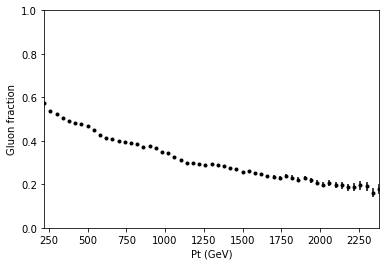

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt


numerator = result['jet_pt'].integrate('partonFlav','Gluon').sum('jetNumb')
denominator = result['jet_pt'].sum('partonFlav').sum('jetNumb')
print(numerator, denominator)

numerator.label = r'$\epsilon$'
ax = hist.plotratio(
    num=numerator,
    denom=denominator,
    error_opts={'color': 'k', 'marker': '.'},
    unc='clopper-pearson'
)

# glu = result['jet_pt'].sum('jetNumb').values()[('Gluon',)]
# tot_parton = result['jet_pt'].sum('jetNumb').sum('partonFlav').values()[()]
# print(glu)
# print(tot_parton)

# glu_frac = np.where(tot_parton > 0., np.divide(glu,tot_parton), 0)

# print(len(result['jet_pt'].axis('pt').centers()))
# print(result['jet_pt'].to_hist())

# print(glu_frac)
# plt.scatter(result['jet_pt'].axis('pt').centers(), glu_frac)

plt.xlabel("Pt (GeV)")
plt.ylabel("Gluon fraction")
plt.ylim([0.,1.0])

<Hist (eta) instance at 0x7fd3adda6070> <Hist (eta) instance at 0x7fd3acd34310>


(0.0, 1.0)

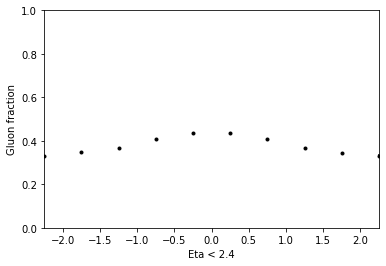

In [5]:
numerator = result['jet_eta'].integrate('partonFlav','Gluon').sum('jetNumb')
denominator = result['jet_eta'].sum('partonFlav').sum('jetNumb')
print(numerator, denominator)

numerator.label = r'$\epsilon$'
ax = hist.plotratio(
    num=numerator,
    denom=denominator,
    error_opts={'color': 'k', 'marker': '.'},
    unc='clopper-pearson'
)

plt.xlabel("Eta < 2.4")
plt.ylabel("Gluon fraction")
plt.ylim([0.,1.0])

<Hist (partonFlav,mass) instance at 0x7fd3acc9e1f0>


/opt/conda/lib/python3.8/site-packages/coffea/hist/plot.py:43: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(


Text(0.5, 0, 'Jet mass (GeV)')

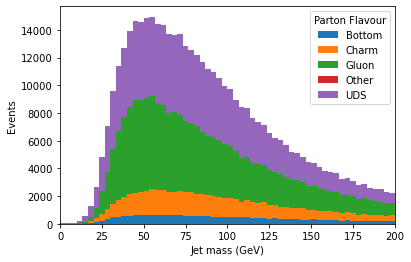

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
# plt.rcParams["figure.figsize"] = (20,5)


# fig, axs = plt.subplots(1, 3)
print(result['jet_mass'].sum('jetNumb'))
hist.plot1d(result['jet_mass'].sum('jetNumb'), stack = True)
#axs[0].set_xlabel("Jet mass (GeV)")
plt.xlabel("Jet mass (GeV)")

In [7]:
glu = result['pt_jet3'].values()[('Gluon',)]
bottom = result['pt_jet3'].values()[('Bottom',)]
charm = result['pt_jet3'].values()[('Charm',)]
uds = result['pt_jet3'].values()[('UDS',)]
tot_parton = glu + bottom + charm + uds

glu_frac = np.where(tot_parton > 0, np.divide(glu,tot_parton), 0)

print(len(result['pt_jet3'].axis('pt').centers()))
print(result['pt_jet3'].to_hist())

print(glu_frac)

plt.scatter(result['pt_jet3'].axis('pt').centers(), glu_frac)
plt.xlim([200,2000])
plt.xlabel("Pt (GeV)")

#sum entries in bins --> plot as y-axis

# hist.plot1d(result['pt_jet2'], ax = axs[1], stack = True)
# axs[1].set_xlabel("Jet2 pt (GeV)")
# hist.plot1d(result['pt_jet1'], ax = axs[2], stack = True)
# axs[2].set_xlabel("Leading jet pt (GeV)")


KeyError: 'pt_jet3'

In [ ]:
# plot mass after summing over partons

In [ ]:
fig, ax = plt.subplots(1, 1)
hist.plot1d(result['pt_jet3'], stack = True)
ax.set_xlabel("Jet3 pT (GeV)")
ax.set_xscale("log")

In [ ]:
fig, ax = plt.subplots(1, 1)
hist.plot1d(result['btag'], stack = True)
ax.set_xlabel("Jet3 b-tag disc.")
#can do an anti b-tag --> inverse of recommendation

In [ ]:
print(result['cutflow']['gluonPuritySum_bloose']/result['cutflow']['chunks'])
print(result['cutflow']['gluonPuritySum_bbmed']/result['cutflow']['chunks'])
print(result['cutflow']['gluonPuritySum_bbloose']/result['cutflow']['chunks'])

In [ ]:
print(result['cutflow']['nGluonJets'])
print(result['cutflow']['nGluonJets_bloose'])

In [ ]:
#plot pt, eta, phi, fake rate, pt efficiency, gluon purity for difference selections with b tags for all jets 
#and each individual jet in the 3 jets